In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

from scipy.spatial.distance import pdist,squareform
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import transformers as ppb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\basuc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
PATH = './bert_uncased_save'
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(PATH)

In [3]:
paragraph = """"The following exercises are recommended for people during early pregnancy.

Kegel exercises, or pelvic floor exercises, work to strengthen the muscles that support the abdominal organs, including the uterus, vagina, bowel, and bladder.

These exercises also help maintain control of bladder function and can reduce the risk of hemorrhoids.

With an empty bladder, squeeze the Kegel muscles and hold the contraction for 5–10 seconds before relaxing. Try to avoid using any surrounding muscles, such as those of the buttocks, legs, or abs.


Walking on a flat, even surface is one of the most gentle, low impact forms of exercise, which makes it ideal for pregnant people.

Swinging the arms in wide, rhythmic movements while walking can result in a moderate increase in heart rate. Walking in a calm, natural setting can also help promote well-being and relaxation.

A person who is unaccustomed to taking walks could begin by taking a few 10-minute walks every week. During the first trimester, people can gradually build up to taking 30-minute walks three to five times per week, if they choose.

People who are accustomed to running can gradually transition from walking to jogging during the first trimester, as long as they use a flat, even surface.

Anyone who is taking prolonged walks or jogs should be sure to wear supportive footwear that fits correctly.

Swimming and water aerobics
Swimming and water aerobics are low impact exercises that can help keep the body toned and do not present a risk of falling.

If a person is accustomed to swimming or doing water aerobics, their usual routine will often be safe during the first trimester of pregnancy.

If a person is new to swimming, they may want to start by taking two or three 30-minute classes each week. Once they become more confident, they could go for 30-minute sessions a few times per week or as often as feels comfortable for them.


Doing yoga allows people to gently stretch and strengthen their body. It also encourages mindfulness skills that can be very helpful during labor, such as controlled breathing and meditation.

Many yoga studios offer classes for pregnant people. People who are new to yoga could try to attend one 30-minute session per week.

People who are accustomed to doing yoga can often continue with their usual routine during early pregnancy.

A person may want to ask a doctor if there are any specific movements, such as lying on the back, that they should avoid.


Pilates can improve core strength and balance, which may reduce the risk of falling. It can also help easeTrusted Source lower back pain associated with weight gain, especially in the front of the body.

People who are new to Pilates could start gradually by doing a few sessions per week, each lasting 5–10 minutes. They can then work their way toward attending sessions lasting 30–60 minutes.

Pregnant people who are accustomed to Pilates can often maintain their usual routine during the first trimester.

Again, a person may want to ask a doctor if there are any specific movements that they should avoid.

Many studios and gyms offer prenatal Pilates classes, and similar lessons are available online.


During the first trimester of pregnancy, it is generally safeTrusted Source to do some moderate weightlifting.

Using free weights and weight machines can help a person manage their weight and improve their overall strength. Having a stronger core can also help improve stability and reduce the risk of falling.

People should be sure to keep the fetus safe by keeping weights in a safe position. They should also consult a doctor, if possible, to find out if there are any specific movements that they should avoid.

People who are new to weightlifting should start gradually and use light free weights.

Off-road cycling, such as mountain biking, is not a good option for pregnant people due to the risk of falling and injury.

Stationary bikes, spin classes, and safe, flat cycling paths are all alternatives with significantly fewer risks.

People who are new to the stationary bike could try cycling for 10–15 minutes at a time. They could then extend their sessions to 30–60 minutes, if comfortable.

If a person is used to spinning or using a stationary bike, they can often maintain their regular routine during the first trimester."""""

In [4]:
paragraph_split = sent_tokenize(paragraph)

In [5]:
len(paragraph_split)

40

In [6]:
input_tokens = []
for i in paragraph_split:
    input_tokens.append(tokenizer.encode(i, add_special_tokens=True))

In [7]:
temp = []
for i in input_tokens:
    temp.append(len(i))
np.max(temp)  

38

In [8]:
input_ids = pad_sequences(input_tokens, maxlen=100, dtype="long", value=0, truncating="post", padding="post")

In [9]:
def create_attention_mask(input_id):
    attention_masks = []
    for sent in input_ids:
        att_mask = [int(token_id > 0) for token_id in sent]  # create a list of 0 and 1.
        attention_masks.append(att_mask)  # basically attention_masks is a list of list
    return attention_masks

In [10]:
input_masks = create_attention_mask(input_ids)

In [11]:
input_ids = torch.tensor(input_ids)  
attention_mask = torch.tensor(input_masks)

In [12]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [13]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [14]:
token_embed = last_hidden_states[0]

In [15]:
token_embed.shape

torch.Size([40, 100, 768])

In [16]:
x_final= mean_pool(token_embed,attention_mask)

In [17]:
x_final.shape

torch.Size([40, 768])

In [18]:
sentence_features = x_final.detach().numpy()

In [19]:
array_similarity = squareform(pdist(sentence_features, metric='euclidean'))

Text(0.5, 1.0, 'visualizing sentence semantic similarity')

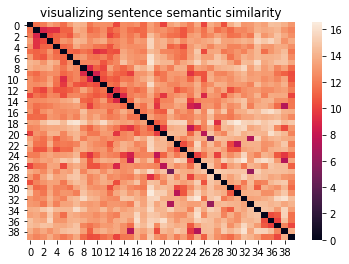

In [20]:
sns.heatmap(array_similarity)
plt.title('visualizing sentence semantic similarity')

In [21]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [22]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

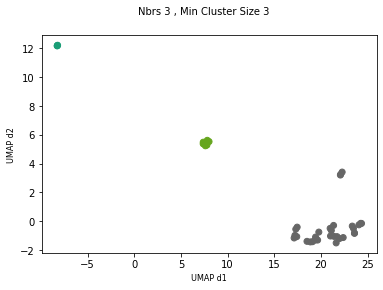

In [23]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(sentence_features)
standard_embedding = umap.UMAP(n_neighbors=3,
                               min_dist=0.0,
                               n_components=2,
                               random_state=42,
                              ).fit_transform(sentence_features)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=3).fit_predict(standard_embedding)
fig = plt.figure()
fig.suptitle('Nbrs 3 , Min Cluster Size 3', fontsize=10)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],c=hdbscan_labels, cmap='Dark2' )
plt.xlabel('UMAP d1', fontsize=8)
plt.ylabel('UMAP d2', fontsize=8)
plt.show()

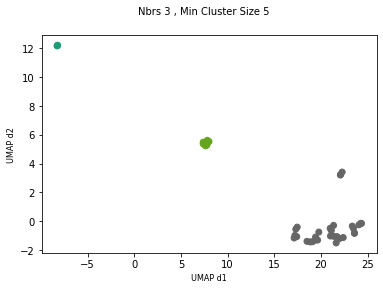

In [24]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(sentence_features)
standard_embedding = umap.UMAP(n_neighbors=3,
                               min_dist=0.0,
                               n_components=2,
                               random_state=42,
                              ).fit_transform(sentence_features)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=5).fit_predict(standard_embedding)
fig = plt.figure()
fig.suptitle('Nbrs 3 , Min Cluster Size 5', fontsize=10)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],c=hdbscan_labels, cmap='Dark2' )
plt.xlabel('UMAP d1', fontsize=8)
plt.ylabel('UMAP d2', fontsize=8)
plt.show()

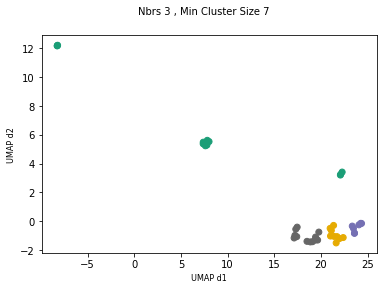

In [25]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(sentence_features)
standard_embedding = umap.UMAP(n_neighbors=3,
                               min_dist=0.0,
                               n_components=2,
                               random_state=42,
                              ).fit_transform(sentence_features)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=7).fit_predict(standard_embedding)
fig = plt.figure()
fig.suptitle('Nbrs 3 , Min Cluster Size 7', fontsize=10)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],c=hdbscan_labels, cmap='Dark2' )
plt.xlabel('UMAP d1', fontsize=8)
plt.ylabel('UMAP d2', fontsize=8)
plt.show()

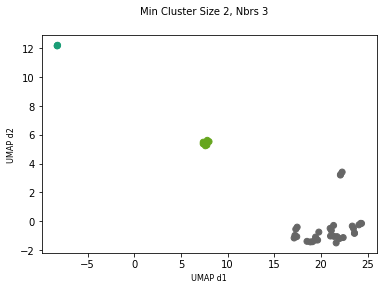

In [26]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(sentence_features)
standard_embedding = umap.UMAP(n_neighbors=3,
                               min_dist=0.0,
                               n_components=2,
                               random_state=42,
                              ).fit_transform(sentence_features)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=2).fit_predict(standard_embedding)
fig = plt.figure()
fig.suptitle('Min Cluster Size 2, Nbrs 3', fontsize=10)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],c=hdbscan_labels, cmap='Dark2' )
plt.xlabel('UMAP d1', fontsize=8)
plt.ylabel('UMAP d2', fontsize=8)
plt.show()

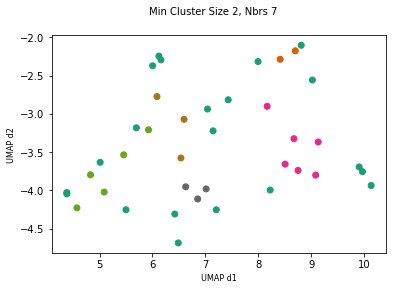

In [27]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(sentence_features)
standard_embedding = umap.UMAP(n_neighbors=7,
                               min_dist=0.0,
                               n_components=2,
                               random_state=42,
                              ).fit_transform(sentence_features)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=2).fit_predict(standard_embedding)
fig = plt.figure()
fig.suptitle('Min Cluster Size 2, Nbrs 7', fontsize=10)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],c=hdbscan_labels, cmap='Dark2' )
plt.xlabel('UMAP d1', fontsize=8)
plt.ylabel('UMAP d2', fontsize=8)
plt.show()

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(sentence_features)
standard_embedding = umap.UMAP(n_neighbors=11,
                               min_dist=0.0,
                               n_components=2,
                               random_state=42,
                              ).fit_transform(sentence_features)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=3).fit_predict(standard_embedding)
fig = plt.figure()
fig.suptitle('Min Cluster Size 2, Nbrs 11', fontsize=10)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],c=hdbscan_labels, cmap='Dark2' )
plt.xlabel('UMAP d1', fontsize=8)
plt.ylabel('UMAP d2', fontsize=8)
plt.show()